In [3]:
import pandas as pd
import numpy as np
GBQ_PROJECT_ID = '620265099307'

import datetime
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib import verbose
#verbose.level = 'helpful'      # one of silent, helpful, debug, debug-annoying

# taken from https://github.com/jrmontag/STLDecompose
# requires installation - pip install stldecompose
from stldecompose import decompose
# Simpler smoothing uses:
# from statsmodels.tsa.seasonal import seasonal_decompose

import geopandas as gpd

In [4]:
q='''
SELECT
  p.practice,
  AVG(total_list_size) AS list_size,
  pct,
  prac.setting,
  p.month,
  SUM(IF(p.bnf_code LIKE '1001030U0%AB',
      items,
      0)) AS mtx_2_5,
  SUM(IF(p.bnf_code LIKE '1001030U0%AC',
      items,
      0)) AS mtx_10,
  SUM(IF(p.bnf_code LIKE '1001030U0%CF'
      OR p.bnf_code LIKE '1001030U0%BT'
      OR p.bnf_code LIKE '1001030U0%BU',
      items,
      0)) AS mtx_liq,
  SUM(IF(p.bnf_code LIKE '1001030U0%AH'
      OR p.bnf_code LIKE'1001030U0%AK'
      OR p.bnf_code LIKE'1001030U0%AS'
      OR p.bnf_code LIKE'1001030U0%AR'
      OR p.bnf_code LIKE'1001030U0%AT'
      OR p.bnf_code LIKE'1001030U0%AV'
      OR p.bnf_code LIKE'1001030U0%AE'
      OR p.bnf_code LIKE'1001030U0%AA'
      OR p.bnf_code LIKE'1001030U0%AF'
      OR p.bnf_code LIKE'1001030U0%AI'
      OR p.bnf_code LIKE'1001030U0%AM',
      items,
      0)) AS mtx_liqspec,
  SUM(CASE WHEN((p.bnf_code LIKE '1001030U0%' OR p.bnf_code LIKE '0801030P0%') AND p.bnf_name LIKE '%Inj %') THEN items
      ELSE 0 END) AS mtx_inj,
  SUM(items) AS total_mtxitems
FROM
  ebmdatalab.brian.methotrexate_subset_normalisedpresc AS p
INNER JOIN
  ebmdatalab.hscic.practices prac
ON
  p.practice = prac.code
  AND (prac.setting = 4
    OR prac.setting = 2)
LEFT JOIN
  ebmdatalab.hscic.practice_statistics_all_years AS stat
ON
  p.practice = stat.practice
  AND p.month = stat.month
GROUP BY
  practice,
  pct,
  setting,
  month
ORDER BY
  practice,
  month
'''

all_mtx = pd.read_gbq(q, GBQ_PROJECT_ID, verbose=False, dialect='standard')
ooh_mtx = all_mtx.loc[all_mtx.setting==2]
gp_mtx = all_mtx.loc[all_mtx.setting==4]
all_mtx.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707686 entries, 0 to 707685
Data columns (total 11 columns):
practice          707686 non-null object
list_size         689661 non-null float64
pct               707686 non-null object
setting           707686 non-null int32
month             707686 non-null datetime64[ns]
mtx_2_5           707686 non-null int32
mtx_10            707686 non-null int32
mtx_liq           707686 non-null int32
mtx_liqspec       707686 non-null int32
mtx_inj           707686 non-null int32
total_mtxitems    707686 non-null int32
dtypes: datetime64[ns](1), float64(1), int32(7), object(2)
memory usage: 40.5+ MB


In [5]:
gp_mtx

,practice,list_size,pct,setting,month,mtx_2_5,mtx_10,mtx_liq,mtx_liqspec,mtx_inj,total_mtxitems
0,Y02757,7002.0,06A,4,2017-12-01,9,0,0,0,0,9
1,Y02757,7016.0,06A,4,2018-01-01,7,1,0,0,0,8
2,Y02757,7020.0,06A,4,2018-02-01,12,1,0,0,0,13
3,Y02757,7026.0,06A,4,2018-03-01,8,0,0,0,0,8
4,Y02757,7062.0,06A,4,2018-04-01,12,0,0,0,0,12
5,Y02767,1605.0,01G,4,2011-01-01,1,0,0,0,0,1
6,Y02767,1605.0,01G,4,2011-02-01,1,0,0,0,0,1
7,Y02767,1605.0,01G,4,2011-03-01,1,0,0,0,0,1
8,Y02767,1869.0,01G,4,2011-04-01,2,0,0,0,0,2
9,Y02767,1869.0,01G,4,2011-05-01,1,0,0,0,0,1


In [6]:
pc = gp_mtx.copy()

pc["2.5mg tabs"] = 100*(pc.mtx_2_5/pc.total_mtxitems).fillna(0)
pc["10mg tabs"] = 100*(pc.mtx_10/pc.total_mtxitems).fillna(0)
pc["liquid"] = 100*(pc.mtx_liq/pc.total_mtxitems).fillna(0)
pc["liquid specials"] = 100*(pc.mtx_liqspec/pc.total_mtxitems).fillna(0)
pc["injections"] = 100*(pc.mtx_inj/pc.total_mtxitems).fillna(0)
pc["10mg measure"] = 100*(pc.mtx_10/(pc.mtx_10+pc.mtx_2_5)).fillna(0)

pc.head()

,practice,list_size,pct,setting,month,mtx_2_5,mtx_10,mtx_liq,mtx_liqspec,mtx_inj,total_mtxitems,2.5mg tabs,10mg tabs,liquid,liquid specials,injections,10mg measure
0,Y02757,7002.0,06A,4,2017-12-01,9,0,0,0,0,9,100.000000,0.000000,0.0,0.0,0.0,0.000000
1,Y02757,7016.0,06A,4,2018-01-01,7,1,0,0,0,8,87.500000,12.500000,0.0,0.0,0.0,12.500000
2,Y02757,7020.0,06A,4,2018-02-01,12,1,0,0,0,13,92.307692,7.692308,0.0,0.0,0.0,7.692308
3,Y02757,7026.0,06A,4,2018-03-01,8,0,0,0,0,8,100.000000,0.000000,0.0,0.0,0.0,0.000000
4,Y02757,7062.0,06A,4,2018-04-01,12,0,0,0,0,12,100.000000,0.000000,0.0,0.0,0.0,0.000000


In [7]:
pc.practice.drop_duplicates().count()

8109

In [8]:
# filter for normal practices
filtered = pc.copy().loc[(pc.list_size>1000) & (pc["month"]>"2010-09-01") ] #ask alex. Is this the first month of data?
filtered.head()

x1 = np.arange(0.1, 1, 0.1)
x2 = np.arange(0.01,0.1,0.01)
x3 = np.arange(0.91, 1, 0.01)
x = np.concatenate((x1,x2,x3))

#filtered tables grouped by months
pcf = filtered.groupby('month').quantile(x)

#putting groupby(month) from index back into being a column
pcf = pcf.reset_index().rename(columns={"level_1": 'percentile'})
pcf

,month,percentile,10mg measure,10mg tabs,2.5mg tabs,injections,liquid,liquid specials,list_size,mtx_10,mtx_2_5,mtx_inj,mtx_liq,mtx_liqspec,setting,total_mtxitems
0,2010-10-01,0.10,0.000000,0.000000,62.500000,0.000000,0.0,0.0,2462.00,0.0,3.00,0.00,0.0,0.0,4.0,3.00
1,2010-10-01,0.20,0.000000,0.000000,77.142857,0.000000,0.0,0.0,3306.60,0.0,5.00,0.00,0.0,0.0,4.0,6.00
2,2010-10-01,0.30,0.000000,0.000000,86.956522,0.000000,0.0,0.0,4177.70,0.0,7.00,0.00,0.0,0.0,4.0,8.00
3,2010-10-01,0.40,0.000000,0.000000,92.857143,0.000000,0.0,0.0,5187.00,0.0,9.00,0.00,0.0,0.0,4.0,11.00
4,2010-10-01,0.50,0.000000,0.000000,98.113208,0.000000,0.0,0.0,6206.50,0.0,12.00,0.00,0.0,0.0,4.0,14.00
5,2010-10-01,0.60,0.000000,0.000000,100.000000,0.000000,0.0,0.0,7352.00,0.0,15.00,0.00,0.0,0.0,4.0,17.00
6,2010-10-01,0.70,8.124655,7.692308,100.000000,0.000000,0.0,0.0,8678.00,1.0,19.00,0.00,0.0,0.0,4.0,22.00
7,2010-10-01,0.80,18.750000,18.229665,100.000000,0.000000,0.0,0.0,10239.20,2.0,25.00,0.00,0.0,0.0,4.0,27.00
8,2010-10-01,0.90,33.389831,33.333333,100.000000,6.976744,0.0,0.0,12446.10,4.0,33.00,1.00,0.0,0.0,4.0,36.00
9,2010-10-01,0.01,0.000000,0.000000,25.000000,0.000000,0.0,0.0,1551.37,0.0,1.00,0.00,0.0,0.0,4.0,1.00


In [9]:
filtered.practice.drop_duplicates().count()

8045

## Practice Level Plots


### Without smoothing

C:\Users\ajwalker\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3471: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


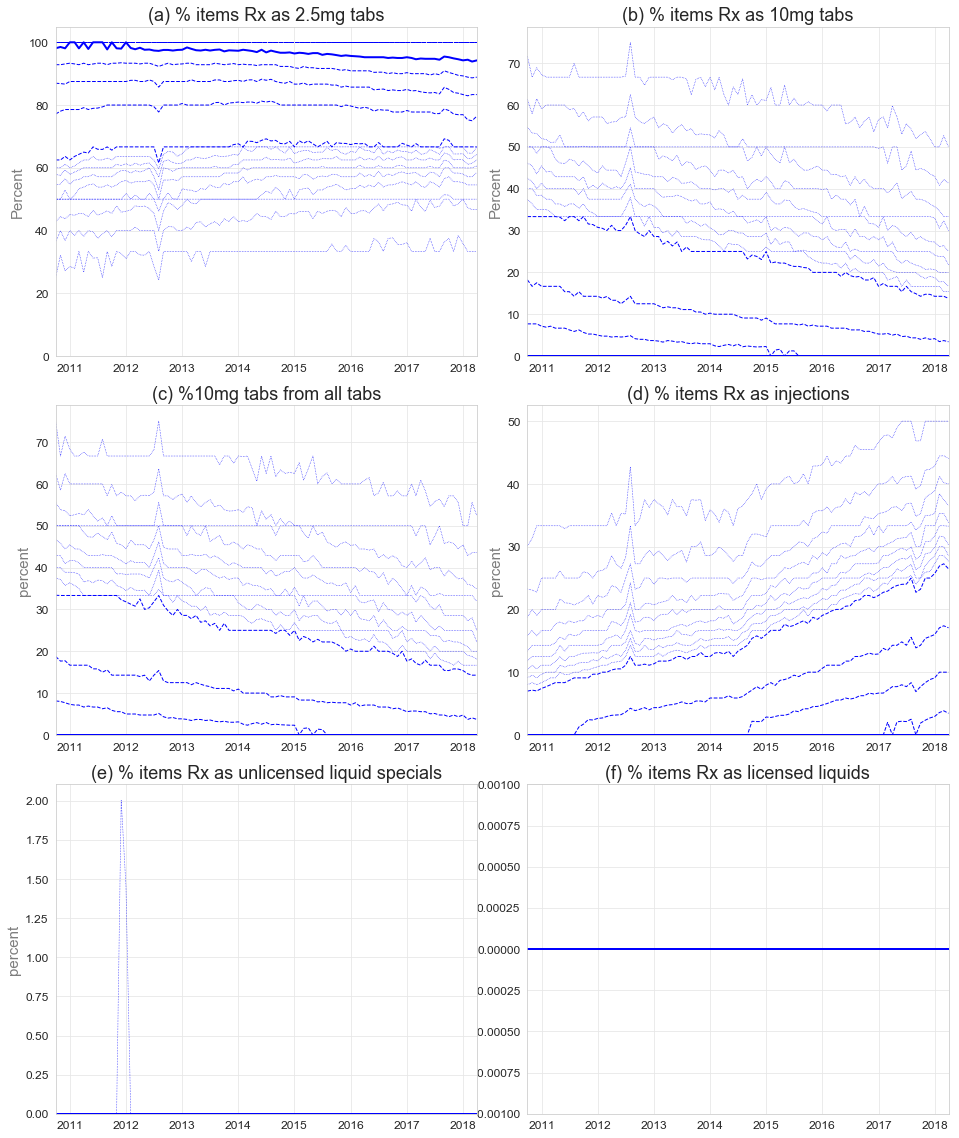

In [10]:
sns.set_style("whitegrid",{'grid.color': '.9'})
dfp = pcf.copy().sort_values(by=["month"])#,"drug"])
dfp['month'] = dfp['month'].astype(str)
# set format for dates:
dfp['dates'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in dfp['month']]

# set sort order of drugs manually, and add grid refs to position each subplot:
# order is column, title, axis
s = [(0,'2.5mg tabs',0,0,'(a) % items Rx as 2.5mg tabs','Percent'), 
     (1,'10mg tabs',0,1,'(b) % items Rx as 10mg tabs','Percent'),
     (2,'10mg measure',1,0, '(c) %10mg tabs from all tabs', 'percent'),
     (3,'liquid',2,1,'(f) % items Rx as licensed liquids','Percent'), # need to check this result, numbers are v.low but graphs might be wrong
     (4,'liquid specials',2,0, '(e) % items Rx as unlicensed liquid specials', 'percent'), # need to check this result, numbers are v.low but graphs might be wrong
     (5,'injections',1,1, '(d) % items Rx as injections', 'percent'),]


x = pd.Series(x)
fig = plt.figure(figsize=(16,20)) 
gs = gridspec.GridSpec(3,2)  # grid layout for subplots

# Plot each subplot using a loop
for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    for decile in x:   # plot each decile line
        data = dfp.loc[(dfp['percentile']==decile)]#(dfp['drug']==i[1]) & 
        if decile == .5:
            ax.plot(data["dates"],data[i[1]],'b-',linewidth=2)
        elif (decile <0.1) | (decile >0.9):
            ax.plot(data["dates"],data[i[1]],'b:',linewidth=0.6)
        else:
            ax.plot(data["dates"],data[i[1]],'b--',linewidth=1)
    ax.set_ylabel(i[5], size =15, alpha=0.6)
    ax.set_title(i[4],size = 18)
    ax.set_ylim([0, dfp[i[1]].max()*1.05])  # set ymax across all subplots as largest value across dataset
    ax.tick_params(labelsize=12)
    ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range

plt.subplots_adjust(wspace = 0.12,hspace = 0.15)
plt.savefig('practice_deciles_no_smooth.png', format='png', dpi=300,bbox_inches='tight')
plt.show()

### need to doublecheck d and e above but absolute numbers are v.low

## With Smoothing

C:\Users\ajwalker\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3471: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))
C:\Users\ajwalker\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3471: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


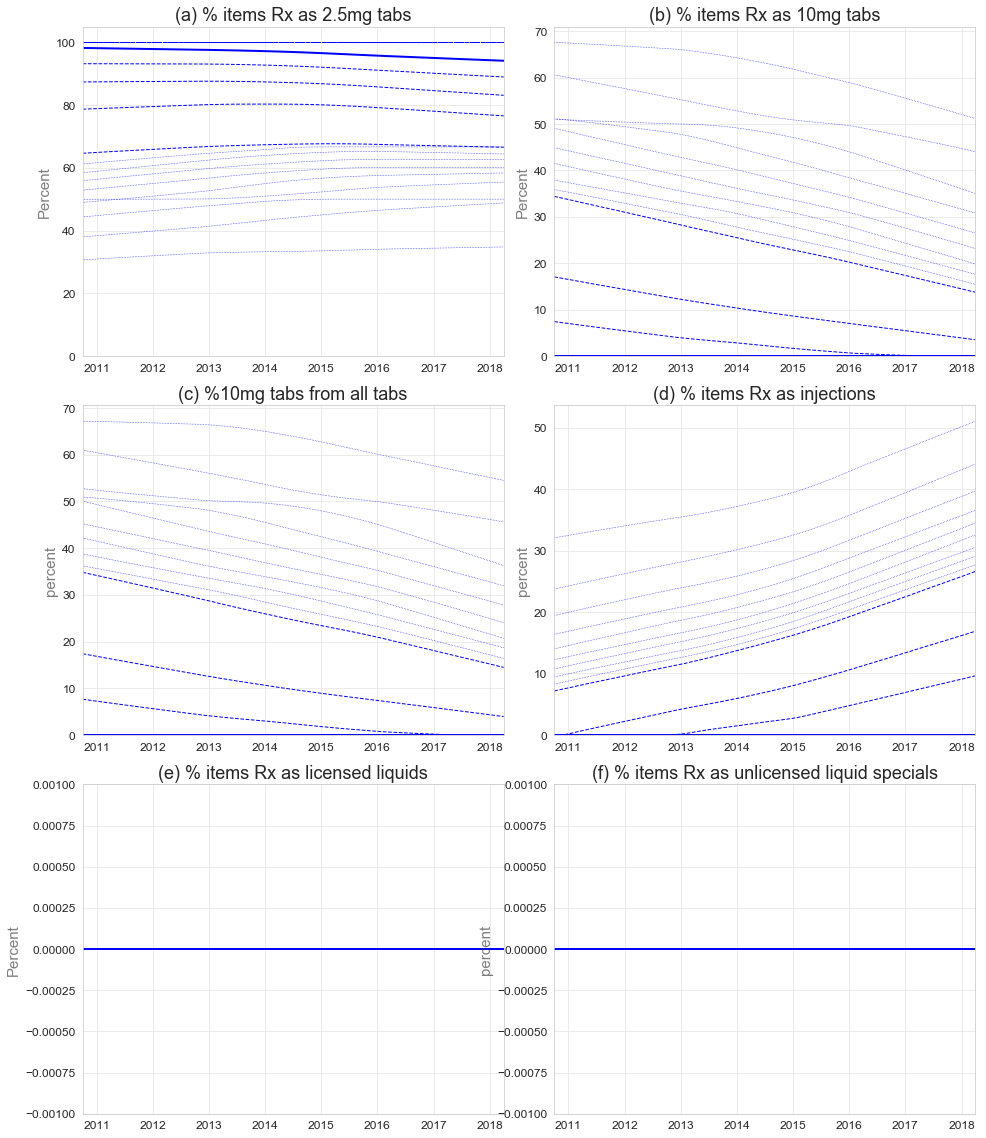

In [11]:
sns.set_style("whitegrid",{'grid.color': '.9'})
dfp = pcf.copy().sort_values(by=["month"])
dfp['month_str'] = dfp['month'].astype(str)
# set format for dates:
dfp['dates'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in dfp['month_str']]

# set sort order of drugs manually, and add grid refs to position each subplot:
s = [(0,'2.5mg tabs',0,0,'(a) % items Rx as 2.5mg tabs','Percent'), 
     (1,'10mg tabs',0,1,'(b) % items Rx as 10mg tabs','Percent'),
     (2,'10mg measure',1,0, '(c) %10mg tabs from all tabs', 'percent'),
     (3,'injections',1,1, '(d) % items Rx as injections', 'percent'),
     (4,'liquid',2,0,'(e) % items Rx as licensed liquids','Percent'),
     (5,'liquid specials',2,1, '(f) % items Rx as unlicensed liquid specials', 'percent'),]
x = pd.Series(x)

fig = plt.figure(figsize=(16,20)) 
gs = gridspec.GridSpec(3,2)  # grid layout for subplots
smry = pd.DataFrame(dfp.dates.drop_duplicates().reset_index(drop=True)) # set up df for outputing results into a table

# Plot each subplot using a loop
for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    for decile in x:   # plot each decile line
        data = dfp.loc[(dfp['percentile']==decile)]
        # for smoothing, dataframe needs to be non-missing and have a DateTime index
        data = data.set_index('month')
        res = data[[i[1]]]
        #res = seasonal_decompose(res, model='additive') # cruder smoothing
        res = decompose(res, period=12, lo_frac=0.6, lo_delta=0.0)
        res = res.trend
        
        if decile == .5:
            ax.plot(data["dates"],res,'b-',linewidth=2)
            smry[i[1]]= res.reset_index()[i[1]]
        elif (decile <0.1) | (decile >0.9):
            ax.plot(data["dates"],res,'b:',linewidth=0.6)
        else:
            #print (data)
            ax.plot(data["dates"],res,'b--',linewidth=1)
    ax.set_ylabel(i[5], size =15, alpha=0.6)
    ax.set_title(i[4],size = 18)
    ax.set_ylim([0, res.max()[0]*1.05])  # set ymax across all subplots as largest value across dataset
    ax.tick_params(labelsize=12)
    ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range

plt.subplots_adjust(wspace = 0.12,hspace = 0.15)
plt.savefig('practice_deciles_smooth.png', format='png', dpi=300,bbox_inches='tight')
plt.show()


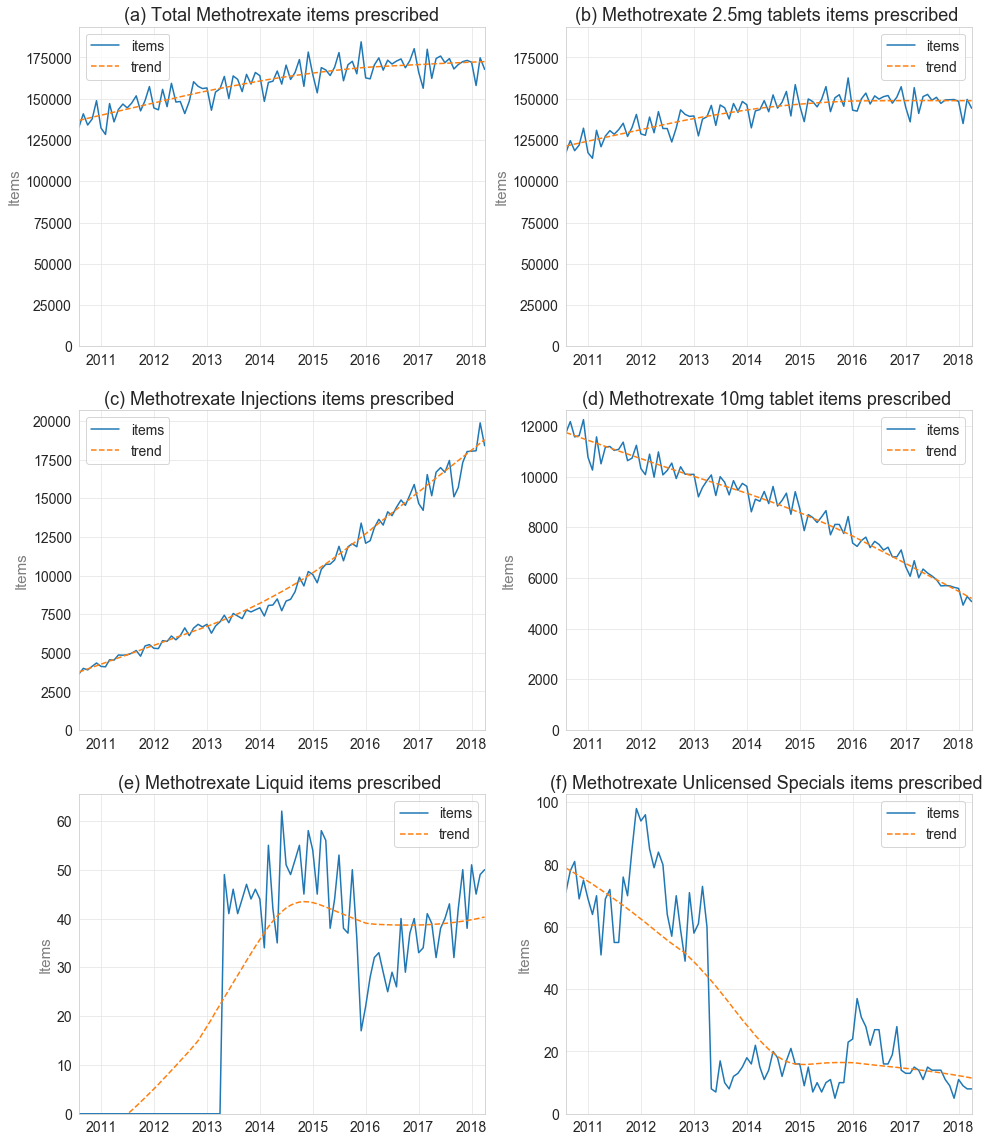

In [12]:
# total items in standard practices = 4

sns.set_style("whitegrid",{'grid.color': '.9'})
dfp = gp_mtx.sort_values(by=["month"])#,"drug"])
dfp['month_str'] = dfp['month'].astype(str)
# set format for dates:
dfp['dates'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in dfp['month_str']]

fig = plt.figure(figsize=(16,20)) 
gs = gridspec.GridSpec(3,2)  # grid layout for subplots


# for smoothing, dataframe needs to be non-missing and have a DateTime index
data = gp_mtx.groupby('month').sum()[['total_mtxitems','list_size']]
data = pd.DataFrame(data['total_mtxitems'])
data['total_mtxitems'] = data["total_mtxitems"]

calc = decompose(data, period=12, lo_frac=0.6, lo_delta=0.0)
average = data.sum()/ (len(data))
flat = ((data-calc.trend))#/data)*100
#total items
ax = plt.subplot(gs[0,0])
ax.plot(data,label='items')
ax.plot(calc.trend,'--',label='trend')
ax.set_ylabel('Items', size =15, alpha=0.6)
ax.set_title('(a) Total Methotrexate items prescribed',size = 18)
ax.tick_params(labelsize=14)
ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
max_value = data["total_mtxitems"].max()*1.05
ax.set_ylim([0,max_value])
ax.legend(prop={'size': 14})


#2.5mg tabs
ax = plt.subplot(gs[0,1])
data = gp_mtx.groupby('month').sum()[['mtx_2_5', 'list_size']]
data = pd.DataFrame(data['mtx_2_5'])

calc = decompose(data, period=12, lo_frac=0.6, lo_delta=0.0)
average = data.sum()/ (len(data))
flat = ((data-calc.trend))

ax.plot(data,label='items')
ax.plot(calc.trend,'--',label='trend')
ax.set_ylabel('Items', size =15, alpha=0.6)
ax.set_title('(b) Methotrexate 2.5mg tablets items prescribed ',size = 18)
ax.tick_params(labelsize=14)
ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
ax.set_ylim([0,max_value])
ax.legend(prop={'size': 14})


#injections
ax = plt.subplot(gs[1,0])
data = gp_mtx.groupby('month').sum()[['mtx_inj','list_size']]
data = pd.DataFrame(data['mtx_inj'])

calc = decompose(data, period=12, lo_frac=0.6, lo_delta=0.0)
average = data.sum()/ (len(data))
flat = ((data-calc.trend))

ax.plot(data,label='items')
ax.plot(calc.trend,'--',label='trend')
ax.set_ylabel('Items', size =15, alpha=0.6)
ax.set_title('(c) Methotrexate Injections items prescribed ',size = 18)
ax.tick_params(labelsize=14)
ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
ax.set_ylim(ymin=0)
ax.legend(prop={'size': 14})


#10mg tablets
ax = plt.subplot(gs[1,1])
data = gp_mtx.groupby('month').sum()[['mtx_10','list_size']]
data = pd.DataFrame(data['mtx_10'])

calc = decompose(data, period=12, lo_frac=0.6, lo_delta=0.0)
average = data.sum()/ (len(data))
flat = ((data-calc.trend))

ax.plot(data,label='items')
ax.plot(calc.trend,'--',label='trend')
ax.set_ylabel('Items', size =15, alpha=0.6)
ax.set_title('(d) Methotrexate 10mg tablet items prescribed ',size = 18)
ax.tick_params(labelsize=14)
ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
ax.set_ylim(ymin=0)
ax.legend(prop={'size': 14})



#liquids 
ax = plt.subplot(gs[2,0])
data = gp_mtx.groupby('month').sum()[['mtx_liq','list_size']]
data = pd.DataFrame(data['mtx_liq'])

calc = decompose(data, period=12, lo_frac=0.6, lo_delta=0.0)
average = data.sum()/ (len(data))
flat = ((data-calc.trend))

ax.plot(data,label='items')
ax.plot(calc.trend,'--',label='trend')
ax.set_ylabel('Items', size =15, alpha=0.6)
ax.set_title('(e) Methotrexate Liquid items prescribed ',size = 18)
ax.tick_params(labelsize=14)
ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
ax.set_ylim(ymin=0)
ax.legend(prop={'size': 14})


#specials - need to be changed
ax = plt.subplot(gs[2,1])
data = gp_mtx.groupby('month').sum()[['mtx_liqspec','list_size']]
data = pd.DataFrame(data['mtx_liqspec'])

calc = decompose(data, period=12, lo_frac=0.6, lo_delta=0.0)
average = data.sum()/ (len(data))
flat = ((data-calc.trend))

ax.plot(data,label='items')
ax.plot(calc.trend,'--',label='trend')
ax.set_ylabel('Items', size =15, alpha=0.6)
ax.set_title('(f) Methotrexate Unlicensed Specials items prescribed ',size = 18)
ax.tick_params(labelsize=14)
ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
ax.set_ylim(ymin=0)
ax.legend(prop={'size': 14})


plt.show()

# # MAPS

In [13]:
#aggregate over last year
ccg_last_year = gp_mtx.groupby(['pct','month'],as_index=False).sum()
ccg_last_year = ccg_last_year.loc[ccg_last_year["month"] >'2017-05-01'] #check when data final


#ccg_last_year = all_mtx_ccg.loc[all_mtx_ccg.month]
ccg_last_year = ccg_last_year.groupby('pct').sum()
ccg_last_year["list_size"] = ccg_last_year["list_size"]/12

ccg_last_year["2.5mg tabs"] = 100*(ccg_last_year.mtx_2_5/ccg_last_year.total_mtxitems).fillna(0)
ccg_last_year["10mg tabs"] = 100*(ccg_last_year.mtx_10/ccg_last_year.total_mtxitems).fillna(0)
ccg_last_year["injections"] = 100*(ccg_last_year.mtx_inj/ccg_last_year.total_mtxitems).fillna(0)
ccg_last_year["total_mtx_items"] = (ccg_last_year.total_mtxitems)/ccg_last_year["list_size"].fillna(0)
ccg_last_year["10mg measure"] = 100*(ccg_last_year.mtx_10/(ccg_last_year.mtx_10+ccg_last_year.mtx_2_5)).fillna(0)

ccg_last_year.head()

,list_size,setting,mtx_2_5,mtx_10,mtx_liq,mtx_liqspec,mtx_inj,total_mtxitems,2.5mg tabs,10mg tabs,injections,total_mtx_items,10mg measure
pct,,,,,,,,,,,,,
00C,99132.000000,484,3521,1,0,0,22,3544,99.351016,0.028217,0.620767,0.035750,0.028393
00D,267178.000000,1668,9302,2,0,0,63,9367,99.306075,0.021352,0.672574,0.035059,0.021496
00J,236551.750000,1364,8705,1,11,0,96,8813,98.774538,0.011347,1.089300,0.037256,0.011486
00K,262766.000000,1380,6256,99,0,0,3,6358,98.395722,1.557093,0.047185,0.024196,1.557828
00L,295240.333333,1864,11588,63,0,0,26,11677,99.237818,0.539522,0.222660,0.039551,0.540726


In [14]:
q='''
SELECT
  DISTINCT code,
  name
FROM
  ebmdatalab.hscic.ccgs
WHERE
  name IS NOT NULL'''

names = pd.read_gbq(q, GBQ_PROJECT_ID, verbose=False, dialect='standard')


In [15]:
# join to geographical data
map_data = ccg_last_year.reset_index()
names = names.rename(columns={"CCG17CDH":"code","CCG17NM":"name"})
map_data = map_data.merge(names[['code','name']],left_on="pct",right_on="code")
map_data['name'] = map_data['name'].str.upper()
map_data['name'] = map_data["name"].str.replace("&","AND")
map_data = map_data.set_index('name')
#map_data = map_data.round(0)
map_data.head() # 207 rows

,pct,list_size,setting,mtx_2_5,mtx_10,mtx_liq,mtx_liqspec,mtx_inj,total_mtxitems,2.5mg tabs,10mg tabs,injections,total_mtx_items,10mg measure,code
name,,,,,,,,,,,,,,,
NHS DARLINGTON CCG,00C,99132.000000,484,3521,1,0,0,22,3544,99.351016,0.028217,0.620767,0.035750,0.028393,00C
"NHS DURHAM DALES, EASINGTON AND SEDGEFIELD CCG",00D,267178.000000,1668,9302,2,0,0,63,9367,99.306075,0.021352,0.672574,0.035059,0.021496,00D
NHS NORTH DURHAM CCG,00J,236551.750000,1364,8705,1,11,0,96,8813,98.774538,0.011347,1.089300,0.037256,0.011486,00J
NHS HARTLEPOOL AND STOCKTON-ON-TEES CCG,00K,262766.000000,1380,6256,99,0,0,3,6358,98.395722,1.557093,0.047185,0.024196,1.557828,00K
NHS NORTHUMBERLAND CCG,00L,295240.333333,1864,11588,63,0,0,26,11677,99.237818,0.539522,0.222660,0.039551,0.540726,00L


In [16]:
from urllib.request import urlopen
from urllib.request import Request
import json
url = "https://openprescribing.net/api/1.0/org_location/?org_type=ccg"
hdr = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11',
       'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
       'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
       'Accept-Encoding': 'none',
       'Accept-Language': 'en-US,en;q=0.8',
       'Connection': 'keep-alive'}
req = Request(url, headers=hdr)
page = urlopen(req)
json_file = json.loads(page.read().decode())
with open('ccgs.json', 'w') as outfile:
    json.dump(json_file, outfile)

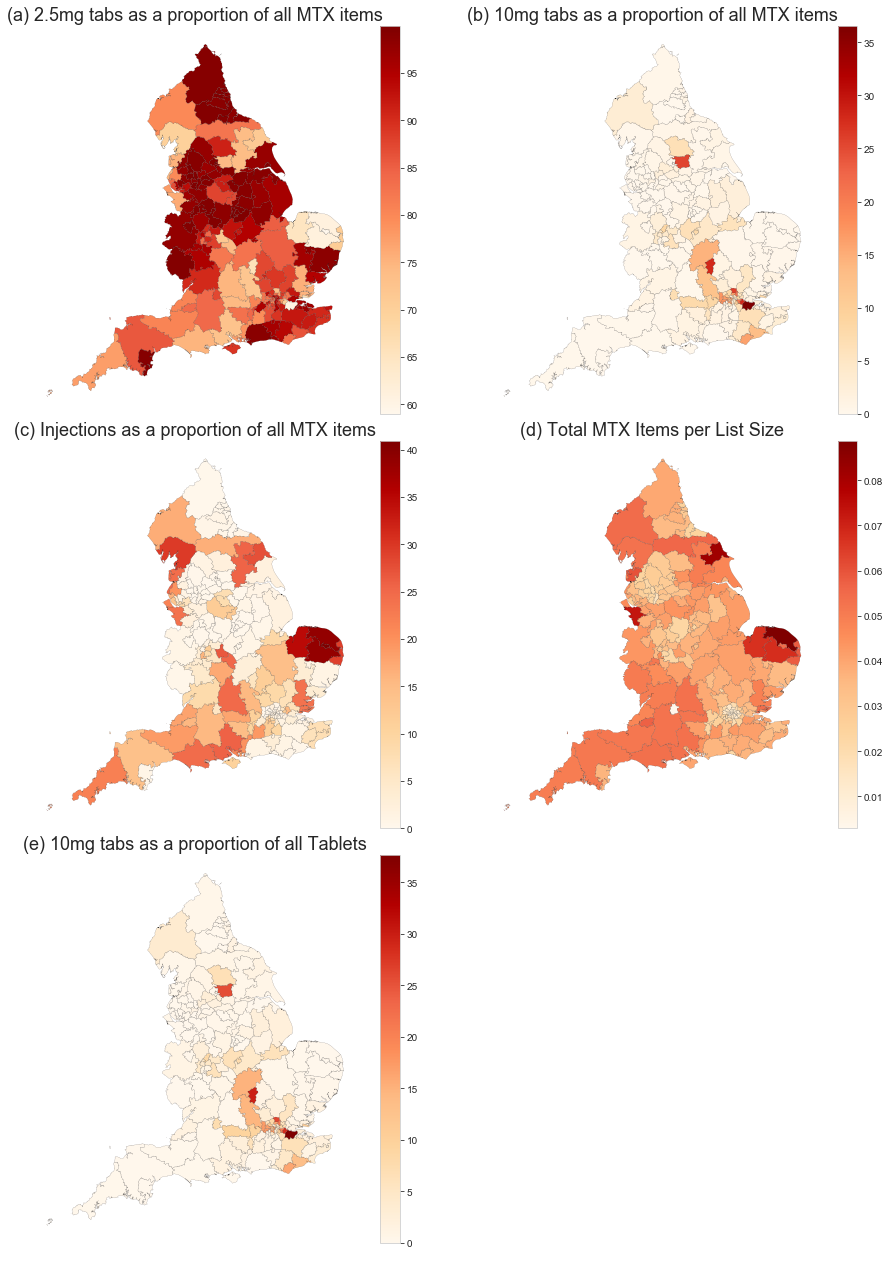

In [17]:
# from our API https://openprescribing.net/api/1.0/org_location/?org_type=ccg
ccgs = gpd.read_file('ccgs.json').set_index('name')

ccgs = ccgs[~ccgs['geometry'].isnull()]  # remove ones without geometry - these are federations rather than individual CCGs
gdf = ccgs.join(map_data)

# set sort order of measures manually, and add grid refs to position each subplot:
s = [(0,'2.5mg tabs',0,0,'(a) 2.5mg tabs as a proportion of all MTX items'), 
     (1,'10mg tabs',0,1,'(b) 10mg tabs as a proportion of all MTX items'),
     (2,'injections',1,0,'(c) Injections as a proportion of all MTX items'),
     (3,'total_mtx_items',1,1, '(d) Total MTX Items per List Size'),
    (4,'10mg measure',2,0, '(e) 10mg tabs as a proportion of all Tablets')]

fig = plt.figure(figsize=(16,30))
gs = gridspec.GridSpec(4,2)  # grid layout for subplots

for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    gdf.plot(ax=ax,column=i[1],  edgecolor='black', linewidth=0.1, legend=True, cmap='OrRd')
    ax.set_aspect(1.63)
    ax.set_title(i[4],size = 18)
    plt.axis('off')

plt.subplots_adjust(wspace = 0.05,hspace = 0.07)
plt.savefig('maps.png', format='png', dpi=300,bbox_inches='tight')

plt.show()

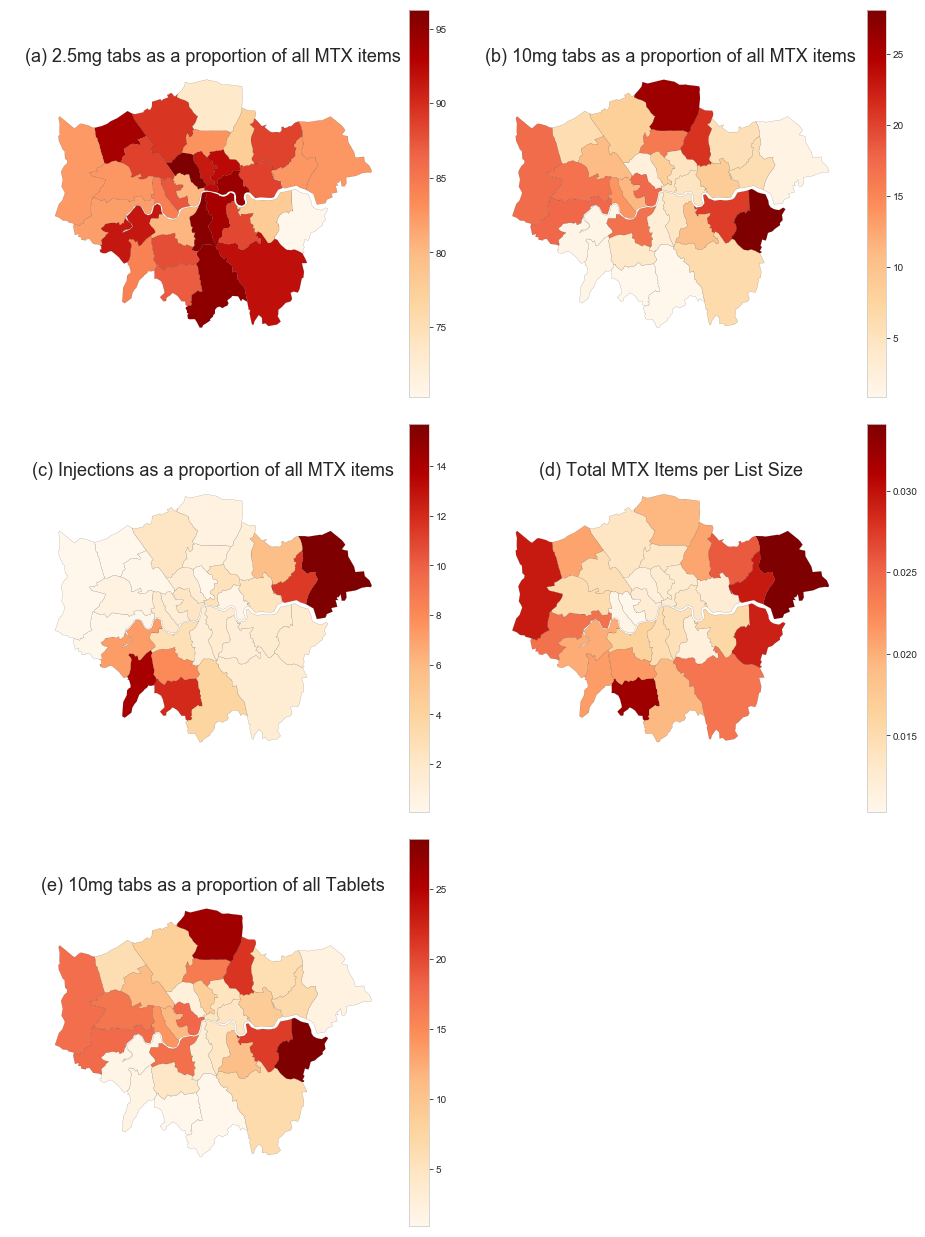

In [18]:
plt.show()# from our API https://openprescribing.net/api/1.0/org_location/?org_type=ccg
ccgs = gpd.read_file('ccgs.json').set_index('name')

ccgs = ccgs[~ccgs['geometry'].isnull()]  # remove ones without geometry - these are federations rather than individual CCGs
gdf = ccgs.join(map_data)
gdf = gdf.loc[(gdf["pct"]=="08H") 
              | (gdf["pct"]=="07L")
              | (gdf["pct"]=="07M")
              | (gdf["pct"]=="07N")
              | (gdf["pct"]=="8M")
              | (gdf["pct"]=="07P")
              | (gdf["pct"]=="07Q")
              | (gdf["pct"]=="07R")
              | (gdf["pct"]=="09A")
              | (gdf["pct"]=="07T")
              | (gdf["pct"]=="07V")
              | (gdf["pct"]=="07X")
              | (gdf["pct"]=="07W")
              | (gdf["pct"]=="08A")
              | (gdf["pct"]=="08C")
              | (gdf["pct"]=="08D")
              | (gdf["pct"]=="08E")
              | (gdf["pct"]=="08F")
              | (gdf["pct"]=="08G")
              | (gdf["pct"]=="07Y")
              | (gdf["pct"]=="08J")
              | (gdf["pct"]=="08K")
              | (gdf["pct"]=="08L")
              | (gdf["pct"]=="08R")
              | (gdf["pct"]=="08Q")
              | (gdf["pct"]=="08T")
              | (gdf["pct"]=="08V")
              | (gdf["pct"]=="08W")
              | (gdf["pct"]=="08X")
              | (gdf["pct"]=="08Y")
              | (gdf["pct"]=="08M")
              | (gdf["pct"]=="08N")
              | (gdf["pct"]=="08P")
              ]             
            #zoom in London

# set sort order of measures manually, and add grid refs to position each subplot:
s = [(0,'2.5mg tabs',0,0,'(a) 2.5mg tabs as a proportion of all MTX items'), 
     (1,'10mg tabs',0,1,'(b) 10mg tabs as a proportion of all MTX items'),
     (2,'injections',1,0,'(c) Injections as a proportion of all MTX items'),
     (3,'total_mtx_items',1,1, '(d) Total MTX Items per List Size'),
    (4,'10mg measure',2,0, '(e) 10mg tabs as a proportion of all Tablets')]

fig = plt.figure(figsize=(16,30))
gs = gridspec.GridSpec(4,2)  # grid layout for subplots

for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    gdf.plot(ax=ax,column=i[1],  edgecolor='black', linewidth=0.1, legend=True, cmap='OrRd')
    ax.set_aspect(1.63)
    ax.set_title(i[4],size = 18)
    plt.axis('off')

plt.subplots_adjust(wspace = 0.05,hspace = 0.07)
plt.savefig('maps.png', format='png', dpi=300,bbox_inches='tight')

plt.show()

## Merge data for regression model (see Stata code)

In [19]:
last_year = all_mtx.loc[(all_mtx.list_size>1000) & (~pd.isnull(all_mtx.list_size)) & (all_mtx["month"]>="2017-01-01")]
last_year = last_year[['practice','pct','mtx_2_5', 'mtx_10', 'list_size']]

last_year = last_year.groupby(['practice','pct'],as_index=False).sum()
last_year['rate'] = last_year['mtx_10']/(last_year['mtx_2_5'] + last_year['mtx_10'])
last_year = last_year[['practice','pct','rate']]
last_year['rate'].quantile([0.1,0.5,0.9])

0.1    0.000000
0.5    0.000000
0.9    0.159332
Name: rate, dtype: float64

In [20]:
last_year.loc[last_year['rate']>0].count()#.hist(bins=50)
#plt.show()

practice    3139
pct         3139
rate        3139
dtype: int64

In [21]:
last_year.loc[last_year['rate']>0]

,practice,pct,rate
1,A81002,00K,0.001144
12,A81016,00M,0.012658
13,A81017,00K,0.016690
15,A81019,00M,0.017730
20,A81025,00K,0.058824
22,A81027,00K,0.026201
23,A81029,00M,0.003676
27,A81033,00M,0.063291
28,A81034,00K,0.025126
33,A81039,00K,0.073710


In [25]:
demographics = pd.read_csv('data_for_regression_2018_10.csv')
demographics = demographics.set_index('practice')
demographics = demographics.drop('pct',axis=1)
demographics.head()

,rural_urban_code,mean_percentile,num_gps_june,num_gps_sept,CL,PH,PHAS,TOTAL,Value_imd,Value_satisfaction,Value_long_term_health,Value_over_65,Value_under_18,dispensing_patients,total_items,list_size,Principal Supplier,Principal System
practice,,,,,,,,,,,,,,,,,,
00D999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
00J999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.0,NaN,NaN,NaN
00M999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
00N999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
01A999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN


In [26]:
merged = last_year.merge(demographics, how='left', left_on='practice', right_index=True)
merged.to_csv('methotrexate_for_analysis.csv')
merged

,practice,pct,rate,rural_urban_code,mean_percentile,num_gps_june,num_gps_sept,CL,PH,PHAS,...,Value_imd,Value_satisfaction,Value_long_term_health,Value_over_65,Value_under_18,dispensing_patients,total_items,list_size,Principal Supplier,Principal System
0,A81001,00K,0.000000,4.0,0.404710,2.0,NaN,425.69,97.00,24.00,...,29.140310,76.020488,57.895013,22.674829,19.722157,0.0,92445.0,4160.416667,TPP,SystmOne
1,A81002,00K,0.001144,4.0,0.495234,12.0,12.0,435.00,97.00,27.00,...,29.689706,85.166335,58.872464,21.025589,18.776949,0.0,457691.0,19945.500000,TPP,SystmOne
2,A81004,00M,0.000000,4.0,0.492813,2.0,3.0,427.63,97.00,27.00,...,34.411828,72.955168,50.053075,18.898240,18.135315,0.0,197867.0,9572.250000,TPP,SystmOne
3,A81005,00M,0.000000,3.0,0.373893,8.0,9.0,429.72,91.76,27.00,...,15.743812,85.118831,52.133158,26.626843,17.585155,0.0,193415.0,7957.583333,TPP,SystmOne
4,A81006,00K,0.000000,4.0,0.426151,8.0,8.0,425.72,97.00,27.00,...,31.791515,85.096769,51.838239,18.484408,20.861205,0.0,330733.0,13844.916667,TPP,SystmOne
5,A81007,00K,0.000000,4.0,0.405190,9.0,10.0,430.68,97.00,27.00,...,32.068038,86.194289,58.507732,18.595632,21.475811,0.0,195468.0,9959.250000,EMIS,EMIS Web
6,A81009,00M,0.000000,4.0,0.371945,5.0,5.0,434.00,87.00,27.00,...,35.263878,66.261000,60.345235,15.063402,22.114123,0.0,210899.0,8956.833333,TPP,SystmOne
7,A81011,00K,0.000000,4.0,0.395093,5.0,5.0,434.96,93.21,27.00,...,34.627062,88.087260,58.803783,18.794049,19.686766,0.0,269270.0,11789.416667,TPP,SystmOne
8,A81012,00M,0.000000,4.0,0.440888,2.0,2.0,418.03,97.00,27.00,...,50.128939,78.702790,65.055366,13.820459,23.206681,0.0,164223.0,4773.500000,TPP,SystmOne
9,A81013,00M,0.000000,3.0,0.462927,4.0,4.0,435.00,97.00,27.00,...,29.955488,91.166242,57.166312,18.513120,22.079689,0.0,157910.0,6304.083333,TPP,SystmOne
